The options for resampling we'll explore in this notebook:

1. librosa
2. scipy.signal
3. resampy
4. Kaldi via torchaudio

Run this notebook with the `test/data` folder from pyannote-audio-v2

In [20]:
!pip install librosa scipy resampy -q

In [28]:
import librosa
librosa.resample
from scipy.signal import resample_poly, resample as resample_fft
import scipy
from IPython.display import Audio
import torchaudio
from time import time
import numpy as np
import torch
from functools import wraps
from torchaudio.transforms import Resample
from functools import partial
from glob import glob

# This is the fastest backend
torchaudio.set_audio_backend('soundfile')

import matplotlib.pyplot as plt
# Nicer looking graphs
plt.style.use('ggplot')


from fastaudio.core.all import AudioToSpec, AudioConfig, AudioTensor, URLs
from fastai.data.all import untar_data

### Alongside quality of the resample, we're also interested in the performance of the resample.

In [29]:
def benchmark(func, num_calls:int=1, name=None):
    """
    This decorator will call the given function 
    and return statistics about how long it ran for
    for each invokation
    """
    
    name = func.__name__ if name == None else name

    @wraps(func)
    def _inner():
        call_times = []
        for i in range(num_calls):
            start = time()
            res = func()
            end = time() - start
            call_times.append(end)
        arr = np.array(call_times)
        return res, arr
    return _inner

#### We're going to use the data from test folder:

In [30]:
speakers_folder = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)
audio_files = speakers_folder.ls()
audio_files

(#3843) [Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00391.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00397.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00219.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00320.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00128.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00384.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00323.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00395.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00391.wav'),Path('/home/harry/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00309.wav')...]

In [31]:
sig, orig_sr = torchaudio.load(audio_files[3])

In [32]:
sig.device, sig.shape, orig_sr

(device(type='cpu'), torch.Size([1, 50560]), 16000)

In [33]:
# Librosa res_types to try
types = ['kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase']

num_of_calls = 10
results = {}

srs = [10000, 9000, 8000, 6000, 4000]
for sr in srs:
    rsr = results[sr] = {}

    # Librosa 
    for i in types:
        func = partial(librosa.resample, sig.numpy()[0], 16000, sr, res_type=i)
        func = benchmark(func, num_of_calls, i)
        rsr[i] = func()
    
    # Kaldi
    res_func = Resample(16000, sr)
    rsr['kaldi'] = benchmark(partial(res_func, sig), num_of_calls, 'kaldi')()

In [34]:
def play_results(results):
    """
    Use this function to hear the difference
    between different methods
    """
    for sr in results:
        print(sr, "============")
        for k in results[sr]:
            item = results[sr][k]
            print(k)
            display(Audio(item[0], rate=int(sr)))

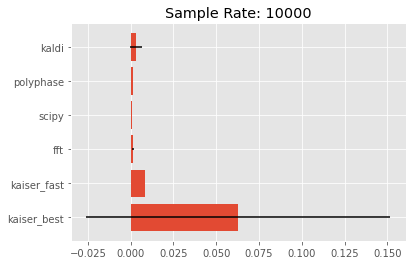

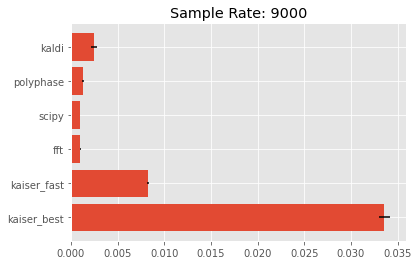

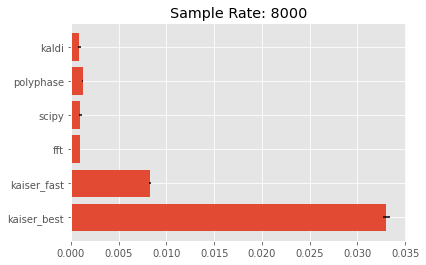

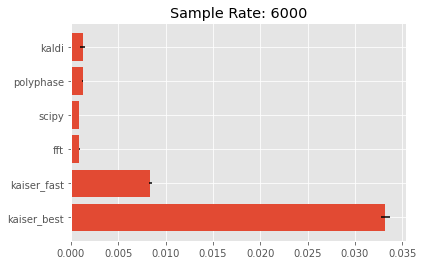

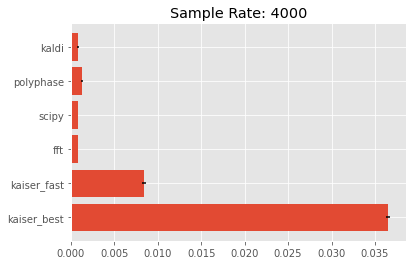

In [35]:
types = [] 
for t in results[srs[0]]:
    types.append(t)

for sr in results:
    times = []
    vars = []
    for k in results[sr]:
        times.append(results[sr][k][1].mean())
        vars.append(results[sr][k][1].std())
    plt.barh(types, times, xerr=vars)
    plt.title("Sample Rate: " + str(sr))
    plt.show()

# Batches
If we did these operations in batches then here is the speeds we would expect

In [36]:
batch = torch.randn(10,1, sig.shape[1]).cuda()
target_sr = 8000
res_func = Resample(16000, target_sr).cuda()

In [37]:
types = ['kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase']
times = []
vars = []
for t in types:
    def resample_batch(batch):
        nb = []
        for sig in batch:
            resampled = librosa.resample(sig.cpu().numpy()[0], 16000, target_sr, res_type=t)
            nb.append(resampled)
        return torch.tensor(nb).cuda().shape
    res = benchmark(partial(resample_batch, batch), 5, t)()[1]
    times.append(res.mean())
    vars.append(res.std())

res = benchmark(partial(res_func, batch), 5, 'kaldi')()[1]
types.append("kaldi")
times.append(res.mean())
vars.append(res.std())

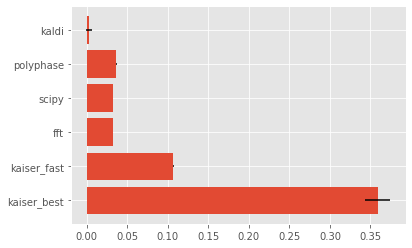

In [38]:
plt.barh(types, times, xerr=vars)
plt.show()

# Quality

The compare the quality of resample methods, a search for a dataset where different types of audio had been recorded through the same device at different sample rates. No luck with this so instead a comparison of the trusted methods from kaiser_best was made to see at what costs to quality are incurred from these speeds. 

We'll use the following metrics to compare the resampling techniques:

### Signal to Noise Ratio

This compares how much of the true signal is in the resulting signal after resample with the added noise in the signal. Higher SNR values mean that the audio is clearer.

### Log Spectral Distance

The Log Spectral Distance shows the restoration of higher frequencies. Lower being better

In [39]:
def signal_to_noise(truth, prediction):
    return 10.*np.log10(np.sqrt(np.sum(truth**2))/np.sqrt(
        np.sum((truth - prediction)**2)))

In [40]:
def log_spectral_distance(truth, prediction):
    s1 = librosa.stft(truth)
    s2 = librosa.stft(prediction)
    true_X = np.log10(np.abs(s1)**2)
    ds_X = np.log10(np.abs(s2)**2)
    ds_X_diff_squared = (true_X - ds_X)**2
    ds_lsd = np.mean(np.sqrt(np.mean(ds_X_diff_squared, axis=0)))
    return ds_lsd

In [41]:
resfunc = Resample(16000, 8000)
best = librosa.resample(sig.numpy()[0], 16000, 8000)
pred = resfunc(sig)

signal_to_noise(best, pred.numpy())
log_spectral_distance(best, pred.numpy()[0])

0.6014384

In [42]:
types = ['kaiser_fast', 'fft', 'scipy', 'polyphase']

results = {}

srs = [10000, 9000, 8000, 6000, 4000]
for sr in srs:
    rsr = results[sr] = {}
    best = librosa.resample(sig.numpy()[0], 16000, sr)
    
    for i in types:
        rsr[i] = {}
        func = partial(librosa.resample, sig.numpy()[0], 16000, sr, res_type=i)
        res = func()
        rsr[i]['SNR'] = signal_to_noise(best, res)
        rsr[i]['LSD'] = log_spectral_distance(best,res)
    
    # Kaldi
    res_func = Resample(16000, sr)
    res = res_func(sig)
    kaldi_results = rsr['kaldi'] = {}
    kaldi_results['SNR'] = signal_to_noise(best, res.numpy())
    kaldi_results['LSD'] = log_spectral_distance(best, res.numpy()[0])

In [43]:
types += ["kaldi"]

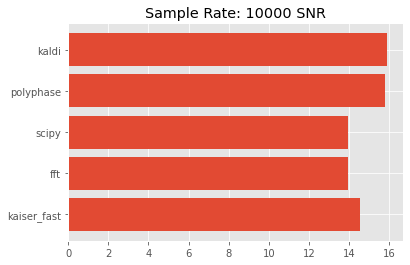

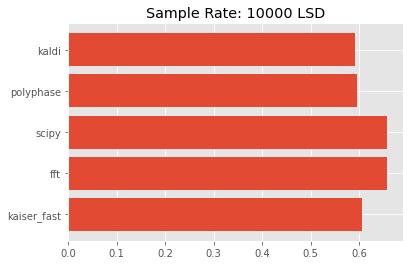

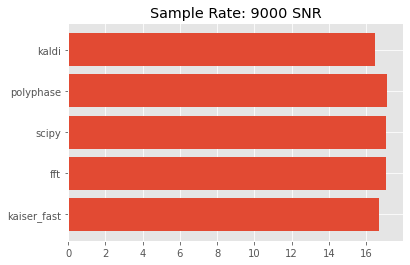

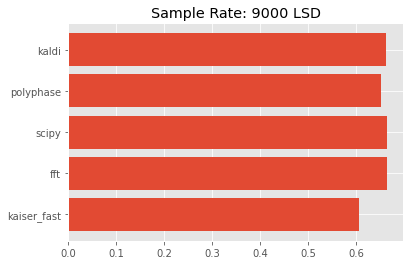

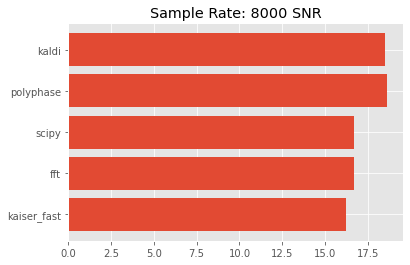

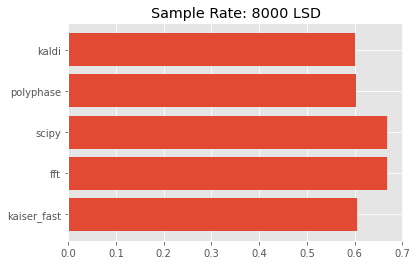

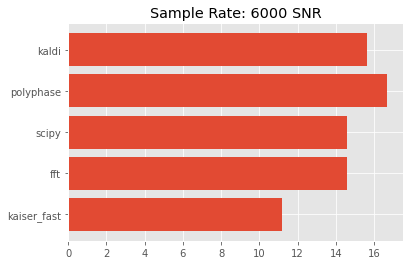

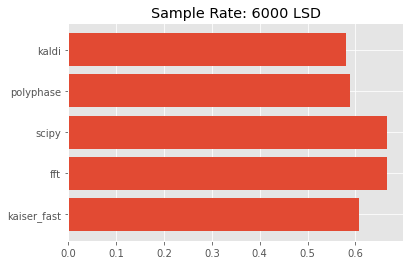

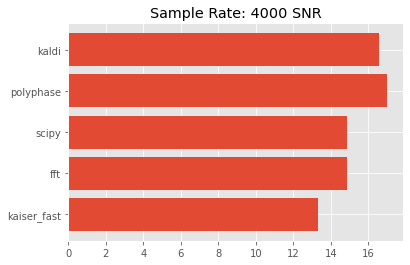

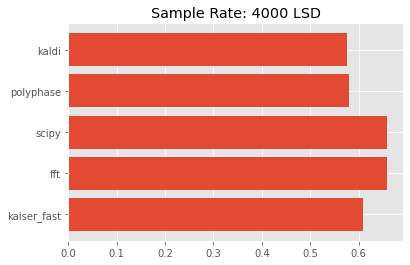

In [44]:
types

for sr in results:
    SNR = []
    LSD = []
    for k in results[sr]:
        SNR.append(results[sr][k]['SNR'])
        LSD.append(results[sr][k]['LSD'])
    plt.barh(types, SNR)
    plt.title(f"Sample Rate: {sr} SNR")
    plt.show()
    
    plt.barh(types, LSD)
    plt.title(f"Sample Rate: {sr} LSD")
    plt.show()

## Certain rates take longer than others

Polyphase resampling's speed is dependent on the GCD between old and new rate. For almost all used sample rates it will be very fast and much better than any FFT based method. It is slow however in the unlikely event that the GCD is small (demonstrated below w GCD of 1 for last 2 examples)

In [51]:
common_downsample = Resample(8000)
slow_downsample = Resample(8001)
slow_upsample = Resample(27101)

In [52]:
%%timeit
common_downsample(sig)

1.84 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
%%timeit
common_downsample(sig)

1.93 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
%%timeit
slow_downsample(sig)

3.24 s ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%%timeit
slow_upsample(sig)

3.54 s ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
